# Question 2
## Part a.
### EIRNN Model

In [121]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np
import math
import logging
import neurogym as ngym
import matplotlib.pyplot as plt
import torch.optim as optim
import neurogym as ngym
import logging

In [122]:
import numpy.matlib

num_units_rec = 5
e_size = 4
i_size = num_units_rec - e_size

# mask_EI_vec = np.concatenate((np.ones((e_size,1)),-1*np.ones((i_size,1)))).T
# mask_EI_mat_plusdiag = np.matlib.repmat(mask_EI_vec,num_units_rec,1)
# diag_mat = np.zeros((num_units_rec,num_units_rec)) + np.diag(np.ones((num_units_rec)))
# mask_EI_mat = mask_EI_mat_plusdiag - diag_mat

mask_no_diag = np.ones((num_units_rec,num_units_rec)) -  np.diag(np.ones((num_units_rec)))

E_I_unit_list = np.concatenate((np.ones((e_size,1)),-1*np.ones((i_size,1)))).T

E_I_mask = mask_no_diag*E_I_unit_list

print(E_I_mask)


[[ 0.  1.  1.  1. -1.]
 [ 1.  0.  1.  1. -1.]
 [ 1.  1.  0.  1. -1.]
 [ 1.  1.  1.  0. -1.]
 [ 1.  1.  1.  1. -0.]]


In [123]:
class EIRecLinear(nn.Module):

    r"""Recurrent E-I Linear transformation.

    This module implements a linear transformation with recurrent E-I dynamics,
    where part of the units are excitatory and the rest are inhibitory.

    Args:
        hidden_size: int, the number of units in the layer.
        e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size) # Number of excitatory units
        self.i_size = hidden_size - self.e_size # Number of inhibitory units

        # Weight matrix for the recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Create a mask to define the E-I interactions
        # The mask has ones for E to E/I and negative ones for I to E/I, except the diagonal

        mask_no_diag = np.ones((self.hidden_size,self.hidden_size)) -  np.diag(np.ones((self.hidden_size)))
        E_I_unit_list = np.concatenate((np.ones((self.e_size,1)),-1*np.ones((self.i_size,1)))).T
        mask = mask_no_diag*E_I_unit_list
        self.mask = torch.tensor(mask, dtype=torch.float32)

        # Optionally add a bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights and biases
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale the weights for the excitatory neurons
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

        # Initialize biases
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        # Apply the mask you have already created to the weights after applying rectification to get the effective weight
        # This ensures that weights from excitatory neurons are positive,
        # and weights from inhibitory neurons are negative.
        eff_W = F.relu(self.weight)*self.mask
        return eff_W

    def forward(self, input):
        # Apply the linear transformation using the effective weights and biases
        # The weights used are non-negative due to the absolute value in effective_weight.
        return F.linear(input, self.effective_weight(), self.bias)

In [124]:

class EIRNN(nn.Module):
    """E-I RNN.

    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size)
        hidden: (batch, hidden_size)
        e_prop: float between 0 and 1, proportion of excitatory neurons
    """

    def __init__(self, input_size, hidden_size, dt=None,
                 e_prop=0.8, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        # Recurrent noise parameter, scaled by the discretization (sqrt(2*alpha)) and noise level (sigma_rec)
        # This adds stochasticity to the recurrent dynamics, possibly simulating biological neural variability
        self._sigma_rec = np.sqrt(2*alpha) * sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        state, output = hidden
        total_input = self.input2h(input) + self.h2h(output)

        state = state * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return state, output

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])
        output = torch.stack(output, dim=0)
        return output, hidden
class Net(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.rnn = EIRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity

In [125]:
# Ensure `PerceptualDecisionMakingDelayResponse` is registered in NeuroGym
task = 'PerceptualDecisionMakingDelayResponse-v0'

# Define timing and environment parameters
timing = {
    'fixation': 500,
    'stimulus': 1000,
    'delay': 1500,
    'decision': 1000,
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 200  # Adjust sequence length to accommodate delay-response structure

# Create dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16, seq_len=seq_len)

# Environment setup
env = dataset.env

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

In [126]:
# Instantiate the EIRNN-based network
hidden_size = 50
net = Net(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

# Optimizer and loss function
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  # Store training losses
running_loss = 0.0
print_step = 200

Net(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)


In [ ]:
for i in range(5000):
    # Load batch
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).float()
    labels = torch.from_numpy(labels)

    # Map labels 1 -> 0, 2 -> 1; handle NaN labels 
    labels = torch.where(labels == 1, torch.tensor(0), labels) 
    labels = torch.where(labels == 2, torch.tensor(1), labels)
    labels = torch.where(labels.isnan(), torch.tensor(-100), labels)
    labels = labels.type(torch.long)

    # Normalise inputs
    inputs = (inputs - inputs.mean()) / (inputs.std() + 1e-7)

    # Zero gradients
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)
    labels = labels.view(-1)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass and gradient clipping
    loss.backward()
    torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
    optimizer.step()

    # Log running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print(f'Step {i+1}, Loss {average_loss:.4f}')
        loss_values.append(average_loss)
        running_loss = 0.0

Step 200, Loss 0.2828
Step 400, Loss 0.2009
Step 600, Loss 0.1914
Step 800, Loss 0.1735
Step 1000, Loss 0.1167
Step 1200, Loss 0.0900
Step 1400, Loss 0.0874
Step 1600, Loss 0.0958
Step 1800, Loss 0.0881
Step 2000, Loss 0.0830
Step 2200, Loss 0.0791
Step 2400, Loss 0.0816
Step 2600, Loss 0.0752
Step 2800, Loss 0.0786
Step 3000, Loss 0.0747
Step 3200, Loss 0.0811
Step 3400, Loss 0.0777
Step 3600, Loss 0.0752
Step 3800, Loss 0.0723
Step 4000, Loss 0.0785
Step 4200, Loss 0.0699
Step 4400, Loss 0.0742
Step 4600, Loss 0.0683
Step 4800, Loss 0.0721
Step 5000, Loss 0.0723


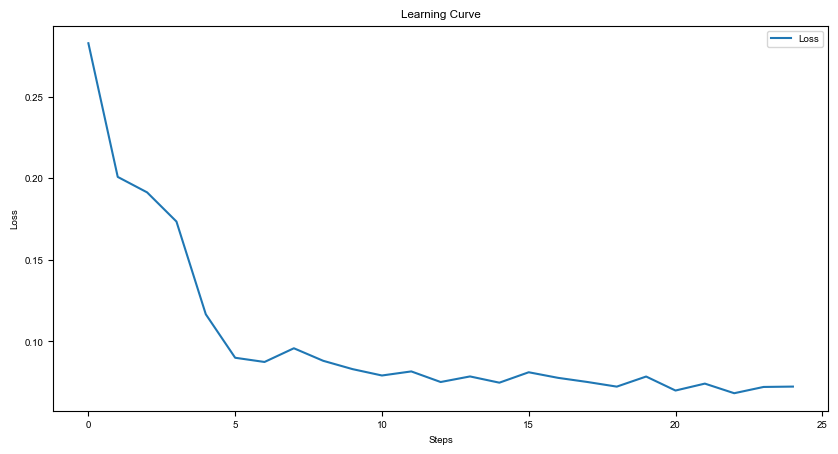

In [132]:
# Plot learning curve
plt.figure(figsize=(10, 5))
plt.title("Learning Curve")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Evaluation on trials (adapted from the EIRNN notebook, but to work specifically with the delay-response task)
env.reset(no_step=True)
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = {0: [], 1: []}  # Adjusted keys to match labels 0 and 1
delay_activity = {0: [], 1: []} # Adjusted keys to match labels 0 and 1

for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt # Get observation and ground truth
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).float() # Add batch dimension
    action_pred, rnn_activity = net(inputs) # Forward pass

    # Compute performance
    action_pred = action_pred.detach().numpy() # Convert to numpy array
    choice = np.argmax(action_pred[-1, 0, :])  # Now choice is 0 or 1
    gt_label = int(gt[~np.isnan(gt)][-1]) # Get ground truth label
    gt_mapped = gt_label - 1  # Map ground truth labels from {1,2} to {0,1} (this is task specific)
    correct = choice == gt_mapped # Check if the choice is correct

    # Log trial info
    trial_info = env.trial # Get trial info
    trial_info.update({'correct': correct, 'choice': choice, 'gt_label': gt_label}) # Add performance info
    trial_infos[i] = trial_info # Log trial info

    # Log activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()  # Get activity for the first trial and remove batch dimension
    activity_dict[i] = rnn_activity # Log activity

    # Log activity during the stimulus period
    stim_start = env.start_ind['stimulus'] # Get stimulus start index
    stim_end = env.end_ind['stimulus'] # Get stimulus end index
    stim_activity[gt_mapped].append(rnn_activity[stim_start:stim_end]) # Log activity

    # Log activity during the delay period
    delay_start = env.start_ind['delay'] # Get delay start index
    delay_end = env.end_ind['delay'] # Get delay end index
    delay_activity[gt_mapped].append(rnn_activity[delay_start:delay_end]) # Log activity

# Compute average performance
correct_trials = [val['correct'] for val in trial_infos.values()] # Get correct trials
accuracy = np.mean(correct_trials) # Compute accuracy
print(f'Model Average Performance on Delay Response Task: {accuracy * 100:.2f}%') 

Model Average Performance on Delay Response Task: 84.80%


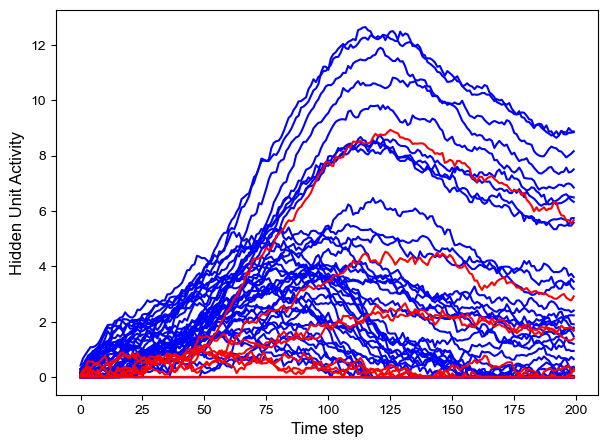

In [130]:
# @title Plot neural activity from sample trials
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

e_size = net.rnn.e_size
trial = 0

plt.figure(figsize=(7, 5))
_ = plt.plot(activity_dict[trial][:, :e_size], color='blue', label='Excitatory')
_ = plt.plot(activity_dict[trial][:, e_size:], color='red', label='Inhibitory')
plt.xlabel('Time step', fontsize=12)
plt.ylabel('Hidden Unit Activity', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


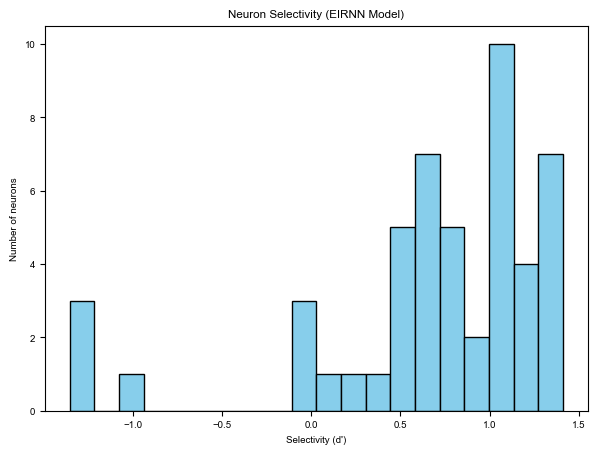

In [137]:
# Compute stimulus selectivity
mean_activity = []
std_activity = []

for ground_truth in [0, 1]:  # Adjust to match dataset labels
    if ground_truth not in stim_activity or len(stim_activity[ground_truth]) == 0:
        print(f"No data for ground truth {ground_truth}, skipping.")
        mean_activity.append(np.zeros(hidden_size))
        std_activity.append(np.zeros(hidden_size))
        continue

    # Concatenate activity across trials for the ground truth label
    activity = np.concatenate(stim_activity[ground_truth], axis=0)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))

# Compute d-prime
epsilon = 1e-7  # Prevent division by zero
selectivity = (mean_activity[1] - mean_activity[0])
selectivity /= np.sqrt((std_activity[1]**2 + std_activity[0]**2 + epsilon) / 2)

# Sort neurons by selectivity
e_size = net.rnn.e_size
ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
                           np.argsort(selectivity[e_size:]) + e_size))

# Plot selectivity distribution
plt.figure(figsize=(7, 5))
plt.hist(selectivity, bins=20, color="skyblue", edgecolor="black")
plt.title("Neuron Selectivity (EIRNN Model)")
plt.xlabel("Selectivity (d')")
plt.ylabel("Number of neurons")
plt.show()

Text(0.5, 1.0, 'Network connectivity')

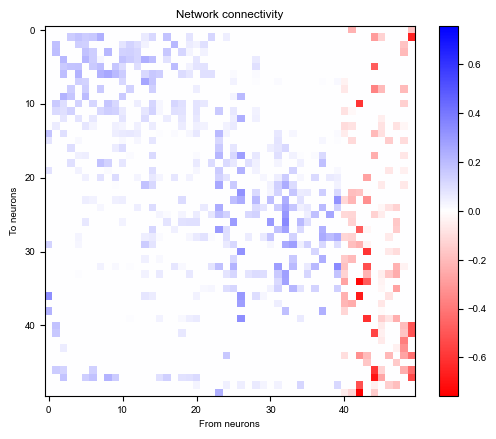

In [138]:
W = net.rnn.h2h.effective_weight().detach().numpy()
# Sort by selectivity
W = W[:, ind_sort][ind_sort, :]
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity')